In [1]:
import torch, os, sys, random, json
from diffusers import AutoencoderKL
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

os.chdir("../scripts/diffuser_icons/")
from dataset import *
from config import ConditionalTrainingConfig
sys.path.append("../diffuser_colored_sq/")
from training_utils import *

In [8]:
max_num_objs = 30
with open("../../data/nouns/all_nouns.txt", "r") as f:
    nouns = [x.strip() for x in f.readlines()][:max_num_objs]
print(len(nouns), nouns[0])
with open("../../data/matplotlib/unicode.jsonl", "r", encoding="unicode-escape") as f: 
    icons = [(json.loads(x)[0], json.loads(x)[2]) for x in f.readlines()][:max_num_objs]
print(len(icons), icons[0])

train_pairs, test_pairs = create_data_split4(nouns, icons)
print(len(train_pairs), len(test_pairs))

30 soda
30 ('∦', 'DejaVuSans')
420 1320


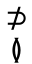

In [9]:
train_pairs[38][1]

In [4]:
vae = AutoencoderKL.from_pretrained("/data/yingshac/clevr_control/from_pretrained/vae/sd2")
#vae = AutoencoderKL.from_single_file("/data/yingshac/clevr_control/from_pretrained/vae/sd2/diffusion_pytorch_model.fp16.bin")

In [47]:
vae.requires_grad_(False)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

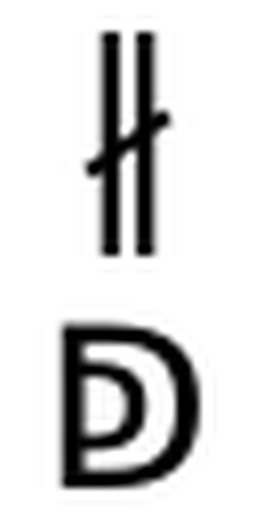

In [12]:
image = train_pairs[8][1].resize((256, 512), Image.LANCZOS)
#image = Image.open("../../notebooks/data/giraffe.jpeg").convert("RGB").resize((224, 224))
image


In [13]:
transform = ToTensor()
input_tensor = transform(image).unsqueeze(0)  # add batch dimension
print("input_tensor.shape = ", input_tensor.shape)
# Encode the image to latent representation
with torch.no_grad():
    #decoded_image = vae(input_tensor).sample.clamp(0, 1)
    latent = vae.encode(input_tensor).latent_dist.sample()

print("latent.shape = ", latent.shape)
# Decode the latent representation back to image
with torch.no_grad():
    decoded_image = vae.decode(latent).sample.clamp(0, 1)

print("decoded_image.shape = ", decoded_image.shape)
# Convert the decoded image tensor to PIL image
to_pil = ToPILImage()
output_image = to_pil(decoded_image.squeeze(0))  # remove batch dimension


input_tensor.shape =  torch.Size([1, 3, 512, 256])
latent.shape =  torch.Size([1, 4, 64, 32])
decoded_image.shape =  torch.Size([1, 3, 512, 256])


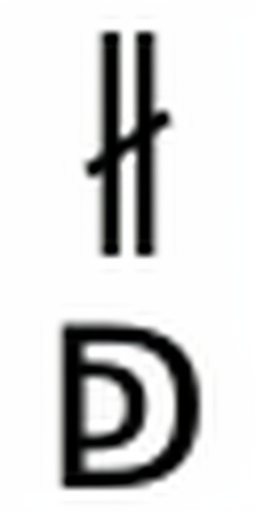

In [14]:
numpy_to_pil(decoded_image.permute(0, 2, 3, 1).numpy())[0]

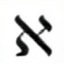

In [52]:
output_image

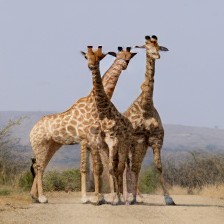

In [35]:
import torchvision
torchvision.transforms.functional.to_pil_image(decoded_image.squeeze(0), mode="RGB")

In [23]:
torch.nn.functional.mse_loss(input_tensor, decoded_image)

tensor(0.0007)